Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
%%capture
! pip install git+https://github.com/LegrandNico/metadPy.git
! pip install numpyro

In [2]:
import numpy as np
import arviz as az
import numpyro
from metadPy.bayesian import hmetad
from metadPy import load_dataset

# Set the number of cores used by Numpyro here
numpyro.set_host_device_count(2)

In this notebook, we are going to estimate meta-*d'* using Bayesian method [**1**] using the `hmetad` function implemented in [metadPy](https://github.com/LegrandNico/metadPy). This function is directly adapted from the [HMeta-d toolbox](https://github.com/metacoglab/HMeta-d), but here it uses [Numpyro](http://num.pyro.ai/en/latest/index.html#) instead of JAGS for MCMC sampling.

# Estimating meta-*d'* at the subject level using Numpyro

## From response-signal arrays

In [3]:
# Create responses data
nR_S1 = np.array([52, 32, 35, 37, 26, 12, 4, 2])
nR_S2 = np.array([2, 5, 15, 22, 33, 38, 40, 45])

The `hmetad()` function from `metadPy.bayesian` can be used pretty much the same way that its MLE alter ego `metadPy.mle.metad()`. Here, it will return two variables. The first one is a function that [Numpyro](http://num.pyro.ai/en/latest/index.html#) uses as a model during the MCMC sampling. The second one is a dictionary containing the posterior samples that can be analyzed using [Arviz](https://arviz-devs.github.io/arviz/) later on. Note that we are specifying the sampling backend as `"numpyro"` here.

In [4]:
model, traces = hmetad(nR_S1=nR_S1, nR_S2=nR_S2, backend="numpyro")

We can then visualize the posterior density estimates. The model returns the *d'* and meta-*d'*. Here, we also plot the `cS1` and `cS2` variables that are internal representations from the model. These variables have no direct utility but they can help to check that the model is sampling correctly. Here the distributions are nicely spaced and spread on each part of the criterion, which is what we expected.

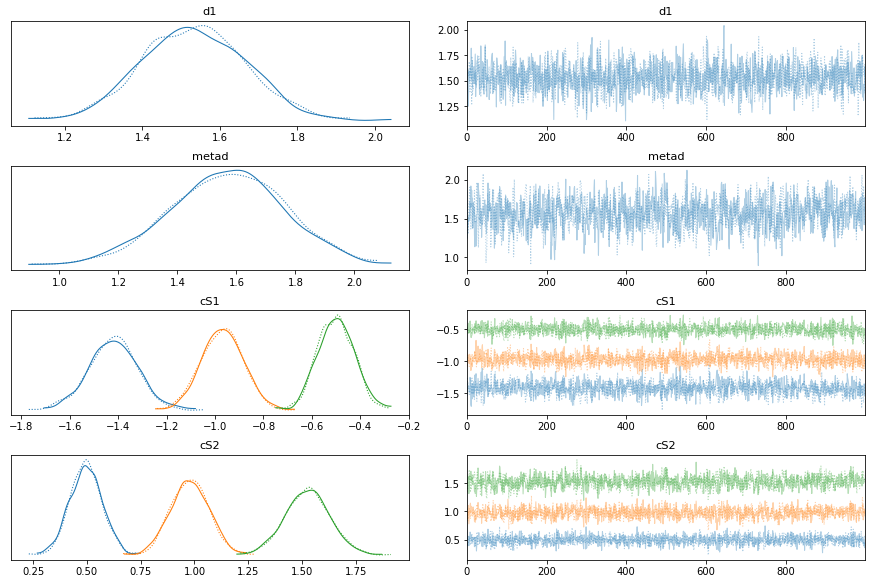

In [5]:
az.plot_trace(traces, var_names=["d1", "metad", "cS1", "cS2"]);

In [6]:
az.summary(traces, var_names=["metad"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
metad,1.569,0.193,1.21,1.934,0.006,0.004,968.0,1327.0,1.0


## From a data frame
The `hmetad()` function can also accept a raw data frame of behavioral data as input, as long as it conforms to the minimum requirements (see [here](https://github.com/LegrandNico/metadPy#importing-data)).

In [7]:
# Let's load some behavioral data from metadPy.
df = load_dataset("rm")

# Just keep one participant and one condition
df = df[(df.Subject == 0) & (df.Condition == 0)]
df.head()

,Stimuli,Responses,Accuracy,Confidence,nTrial,Subject,Condition
0,0,0,1,4,0,0,0
1,1,1,1,4,1,0,0
2,0,1,0,4,2,0,0
3,1,0,0,1,3,0,0
4,1,1,1,2,4,0,0


Here, we simply provide the data frame and point to the columns coding for stimuli, accuracy and confidence. Also, here we explicitly set the number of ratings available for the confidence (4) as the model cannot retrieve it from the data only (which is possible when using response-signal arrays).

In [8]:
model, traces = hmetad(
    data=df, 
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    nRatings=4,
    backend="numpyro")

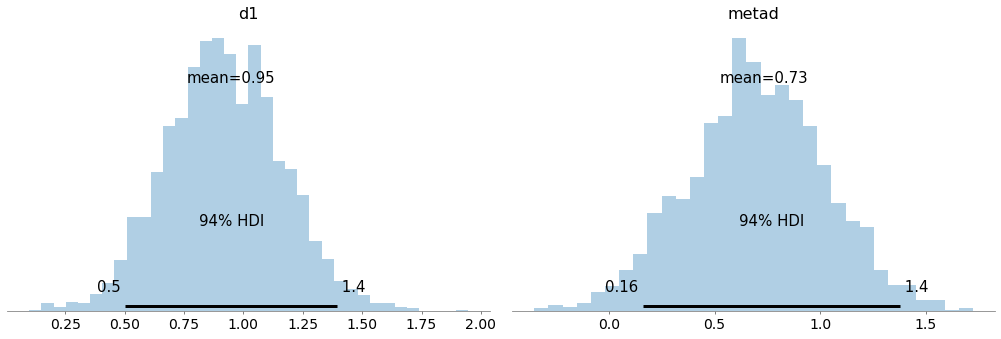

In [9]:
az.plot_posterior(traces, var_names=["d1", "metad"], kind="hist");

# References

[**1**] Fleming, S.M. (2017) HMeta-d: hierarchical Bayesian estimation of metacognitive efficiency from confidence ratings, Neuroscience of Consciousness, 3(1) nix007, https://doi.org/10.1093/nc/nix007